Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables
# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ''

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LogisticRegression
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import plot_rank_performance, run_stan_model

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())


In [3]:
rng = np.random.default_rng(rand_seed)


In [4]:
example_name = 'uci wine example'


In [5]:
if do_display:
    print(example_name)


uci wine example


In [6]:
if example_name=='uci wine example':
    # read data and set scale of system
    features_frame = pd.read_csv('uci_wine_example_features.csv')
    features_scores = pd.read_csv('uci_wine_example_scores.csv')
    score_name = 'logistic_score'
    m_examples : int = 100
    noise_scale = 3.87
    position_penalty_scale = -2.7123
elif example_name=='sklearn wine example':
    # read data and set scale of system
    features_frame = pd.read_csv('sklearn_wine_example_features.csv')
    features_scores = pd.read_csv('sklearn_wine_example_scores.csv')
    score_name = 'score'
    m_examples : int = 100
    noise_scale = 18.7
    position_penalty_scale = -13.123
else:
    raise("bad option")


In [7]:
features_frame.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [8]:
features_frame.shape


(6497, 11)

In [9]:
collected_stats = []

In [10]:
n_alternatives : int = 5


In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:
position_penalties = [position_penalty_scale * i for i in range(n_alternatives)]

position_penalties


[-0.0, -2.7123, -5.4246, -8.1369, -10.8492]

In [13]:
# assemble panels of observations with top scoring entry picked
observations = dict()
for sel_i in range(n_alternatives):
        observations[f'display_position_{sel_i}'] = [sel_i] * m_examples
        selected_examples = rng.choice(features_frame.shape[0], size=m_examples, replace=True)
        observations[f'item_id_{sel_i}'] = selected_examples
        observations[f'score_value_{sel_i}'] = [  # noisy observation of score plus position penalty
                features_scores.loc[int(selected_examples[i]), score_name]               # item score
                + position_penalties[sel_i]                                              # positional penalty
                + noise_scale * rng.normal(size=1)[0]                                    # observation noise
                for i in range(m_examples)
        ]
        observations[f'pick_value_{sel_i}'] = [0] * m_examples
observations = pd.DataFrame(observations)
# mark selections
for i in range(m_examples):
        best_j = 0
        for j in range(1, n_alternatives):
                if observations[f'score_value_{j}'][i] > observations[f'score_value_{best_j}'][i]:
                        best_j = j
        observations.loc[i, f'pick_value_{best_j}'] = 1
observations = (
        observations
                .loc[:, [c for c in observations.columns if not c.startswith('score_value_')]]
                .reset_index(drop=True, inplace=False)
)

observations.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,0,1,1754,0,2,6425,1,3,2780,0,4,2646,0
1,0,4390,1,1,2031,0,2,2692,0,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,0,1,2324,0,2,5815,0,3,1819,1,4,4567,0
4,0,2063,0,1,6283,0,2,3610,1,3,2085,0,4,5610,0


In [14]:
observations.loc[:, [c for c in observations.columns if c.startswith('pick_value_')]].mean(axis=0)


pick_value_0    0.51
pick_value_1    0.32
pick_value_2    0.10
pick_value_3    0.06
pick_value_4    0.01
dtype: float64

In [15]:
observations[
    [c for c in observations.columns if not c.startswith('item_id_')]
    ].head(10)


,display_position_0,pick_value_0,display_position_1,pick_value_1,display_position_2,pick_value_2,display_position_3,pick_value_3,display_position_4,pick_value_4
0,0,0,1,0,2,1,3,0,4,0
1,0,1,1,0,2,0,3,0,4,0
2,0,1,1,0,2,0,3,0,4,0
3,0,0,1,0,2,0,3,1,4,0
4,0,0,1,0,2,1,3,0,4,0
5,0,1,1,0,2,0,3,0,4,0
6,0,1,1,0,2,0,3,0,4,0
7,0,1,1,0,2,0,3,0,4,0
8,0,1,1,0,2,0,3,0,4,0
9,0,1,1,0,2,0,3,0,4,0


In [16]:
# This is the data
observations[
    [c for c in observations.columns if not c.startswith('display_position_')]
    ].head(10)


,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,0,1754,0,6425,1,2780,0,2646,0
1,4390,1,2031,0,2692,0,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,0,2324,0,5815,0,1819,1,4567,0
4,2063,0,6283,0,3610,1,2085,0,5610,0
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,1,1374,0,312,0,926,0,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [17]:
score_compare_frame = pd.DataFrame({
    'hidden concept': features_scores[score_name],
})


Try a Stan model.


In [18]:
# swap all observed alternatives selections into picked position
observations_sorted = observations.copy()
for passed_i in range(1, n_alternatives):
    for row_i in range(m_examples):
        if observations_sorted.loc[row_i, f'pick_value_{passed_i}'] > 0:
            # swap where data is stored in row
            for dest_col, source_col in (
                ('display_position_0', f'display_position_{passed_i}'),
                ('item_id_0', f'item_id_{passed_i}'),
                ('pick_value_0', f'pick_value_{passed_i}'),
                ):
                v_source = observations_sorted.loc[row_i, source_col]
                v_dest = observations_sorted.loc[row_i, dest_col]
                observations_sorted.loc[row_i, source_col] = v_dest
                observations_sorted.loc[row_i, dest_col] = v_source


In [19]:
observations_sorted.head(10)


,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,2,6425,1,1,1754,0,0,1569,0,3,2780,0,4,2646,0
1,0,4390,1,1,2031,0,2,2692,0,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,3,1819,1,1,2324,0,2,5815,0,0,1392,0,4,4567,0
4,2,3610,1,1,6283,0,0,2063,0,3,2085,0,4,5610,0
5,0,2010,1,1,1465,0,2,6388,0,3,25,0,4,420,0
6,0,5903,1,1,1374,0,2,312,0,3,926,0,4,5467,0
7,0,5194,1,1,3651,0,2,1494,0,3,1749,0,4,5865,0
8,0,5946,1,1,4527,0,2,5988,0,3,3021,0,4,4821,0
9,0,6469,1,1,6044,0,2,2787,0,3,5786,0,4,3709,0


In [20]:
observations_sorted[
    [c for c in observations_sorted.columns if not c.startswith('item_id_')]
    ].head(10)


,display_position_0,pick_value_0,display_position_1,pick_value_1,display_position_2,pick_value_2,display_position_3,pick_value_3,display_position_4,pick_value_4
0,2,1,1,0,0,0,3,0,4,0
1,0,1,1,0,2,0,3,0,4,0
2,0,1,1,0,2,0,3,0,4,0
3,3,1,1,0,2,0,0,0,4,0
4,2,1,1,0,0,0,3,0,4,0
5,0,1,1,0,2,0,3,0,4,0
6,0,1,1,0,2,0,3,0,4,0
7,0,1,1,0,2,0,3,0,4,0
8,0,1,1,0,2,0,3,0,4,0
9,0,1,1,0,2,0,3,0,4,0


In [21]:
observations_sorted[
    [c for c in observations_sorted.columns if (not c.startswith('item_id_')) and (not c.startswith('pick_value_'))]
    ].head(10)


,display_position_0,display_position_1,display_position_2,display_position_3,display_position_4
0,2,1,0,3,4
1,0,1,2,3,4
2,0,1,2,3,4
3,3,1,2,0,4
4,2,1,0,3,4
5,0,1,2,3,4
6,0,1,2,3,4
7,0,1,2,3,4
8,0,1,2,3,4
9,0,1,2,3,4


In [22]:
assert np.all(observations_sorted['pick_value_0'] == 1)
for sel_i in range(1, n_alternatives):
    assert np.all(observations_sorted[f'pick_value_{sel_i}'] == 0)


In [23]:
stan_model_panel_src = (
"""
data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
"""
  + ''.join([f"""  matrix[m_examples, n_vars] x_passed_{i};   // character of passed examples
""" for i in range(1, n_alternatives)])
  + """}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
"""
  + ''.join([f"""  vector[m_examples] expect_passed_{i};
""" for i in range(1, n_alternatives)])
  + """  expect_picked = x_picked * beta;          // modeled expected score of picked item
  v_picked = expect_picked + error_picked;  // reified actual score of picked item
"""
  + ''.join([f"""  expect_passed_{i} = x_passed_{i} * beta;      // modeled expected score of passed item
""" for i in range(1, n_alternatives)])
  +"""}
model {
    // basic priors
  beta ~ normal(0, 10);
  error_picked ~ normal(0, 10);
    // log probability of observed ordering as a function of parameters
    // terms are independent conditioned on knowing value of v_picked!
"""
  + ''.join([f"""  target += normal_lcdf( v_picked | expect_passed_{i}, 10);
""" for i in range(1, n_alternatives)])
  + """}
"""
)

if do_display:
  print(stan_model_panel_src)



data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [24]:
def fmt_array(a) -> str:
    return json.dumps([v for v in a])

def mk_posn_indicator(posn: int) -> str:
    posn_indicators = [0] * n_alternatives
    posn_indicators[posn] = 1
    return posn_indicators

def f_i(sel_i: int) -> str:
    id_seq = observations_sorted[f'item_id_{sel_i}']
    posn_seq = observations_sorted[f'display_position_{sel_i}']
    return fmt_array([
        list(features_frame.loc[int(id), :]) + mk_posn_indicator(int(posn))
        for id, posn in zip(id_seq, posn_seq)])

data_str = (f"""
{{
 "n_vars" : {n_vars},
 "m_examples" : {m_examples},
 "x_picked" : {f_i(0)},
"""
    + """,
""".join([f""" "x_passed_{i}" : {f_i(i)}""" for i in range(1, n_alternatives)])
    + """
}
"""
)


In [25]:

fit = run_stan_model(
        stan_model_src=stan_model_panel_src,
        data_str=data_str,
)

In [26]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=['lp__'])

wt_frame


,lp__
0,-138.504
1,-136.693
2,-142.415
3,-144.332
4,-140.374
...,...
3995,-146.608
3996,-136.845
3997,-153.061
3998,-140.968


In [27]:
if do_display:
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x='lp__'),
        )
        + geom_density(fill='gray', alpha=0.7)
        + ggtitle(f'{example_name} Stan lp__ value on panel draws')
    )

In [28]:
beta_draws = fit.draws_pd(vars=['beta'])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) + [f'position_effect_{sel_i}' for sel_i in range(n_alternatives)]

beta_draws_display


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,position_effect_0,position_effect_1,position_effect_2,position_effect_3,position_effect_4
0,-0.402389,-6.649930,1.15154,-0.233640,-12.91020,0.074050,-0.007677,-6.68304,-4.06588,11.99860,1.809850,13.567300,5.50186,-0.212394,-6.433840,-10.20260
1,1.427200,0.953022,-10.55980,-0.092062,-4.88915,-0.171172,0.069147,-10.25310,9.56524,16.55870,-0.122612,10.073000,9.00658,-1.467600,-1.265810,-10.70140
2,-0.335033,-7.836450,-10.91290,0.367960,3.55145,-0.011037,0.010374,5.99965,2.64896,7.19496,3.047880,11.516000,6.03550,-1.555630,-6.325260,-14.36620
3,0.892992,-4.224730,-4.34118,0.523656,1.38895,0.169364,-0.078741,9.23078,10.97620,-2.48098,0.872587,-0.901489,-3.99714,-12.388600,-16.553000,-19.59320
4,-0.950427,0.007919,1.59200,0.300788,2.60701,-0.253446,0.057701,-10.60010,-2.10804,9.22129,3.306490,17.145000,11.22570,1.784610,0.263936,-10.07010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.156870,-3.600030,4.55102,0.173903,-16.23830,-0.037525,-0.003940,10.44970,15.57600,2.81738,2.037360,12.184200,5.27555,-0.107859,-4.551680,-22.83470
3996,-0.212461,2.155930,-12.28960,0.106669,4.88475,0.003218,0.017781,8.86531,2.67373,8.73665,1.600310,13.866600,7.79494,-1.041850,-2.546940,-4.88002
3997,0.243051,10.139200,3.85425,0.065783,1.65160,-0.020202,0.036419,-11.91270,1.92608,-6.90136,2.342090,7.863940,5.33807,-2.475060,-6.307850,-21.18750
3998,-0.343281,2.625600,3.82352,-0.017818,19.19100,0.039556,0.001468,-17.74430,6.37003,-6.45656,1.513350,7.291310,2.44639,-2.747630,-4.089740,-14.22620


In [29]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[wt_frame['lp__'] >= np.quantile(wt_frame['lp__'], 0.9), :].mean()
#estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan


fixed_acidity            0.628757
volatile_acidity        -3.458051
citric_acid             -3.502720
residual_sugar           0.239765
chlorides                1.303403
free_sulfur_dioxide     -0.023147
total_sulfur_dioxide     0.008042
density                 -0.209930
pH                       6.695129
sulphates                5.599832
alcohol                  2.012085
position_effect_0       11.552561
position_effect_1        7.053446
position_effect_2       -0.803168
position_effect_3       -3.961289
position_effect_4      -11.575931
dtype: float64

In [30]:
position_quantiles = (
    beta_draws
        .iloc[:, features_frame.shape[1]:n_vars]
        .quantile((0.25, 0.5, 0.75))
        .transpose()
        .reset_index(drop=True, inplace=False)
)
position_quantiles.columns = [str(c) for c in position_quantiles.columns]


estimated position influences


,position,estimated effect,actual effect,0.25,0.5,0.75
0,posn_0,11.552561,-0.0000,8.315648,11.528600,14.781525
1,posn_1,7.053446,-2.7123,3.426485,6.651755,9.996995
2,posn_2,-0.803168,-5.4246,-4.420350,-1.265465,1.980007
3,posn_3,-3.961289,-8.1369,-7.755128,-4.323185,-0.964758
4,posn_4,-11.575931,-10.8492,-15.807975,-12.046250,-8.313807


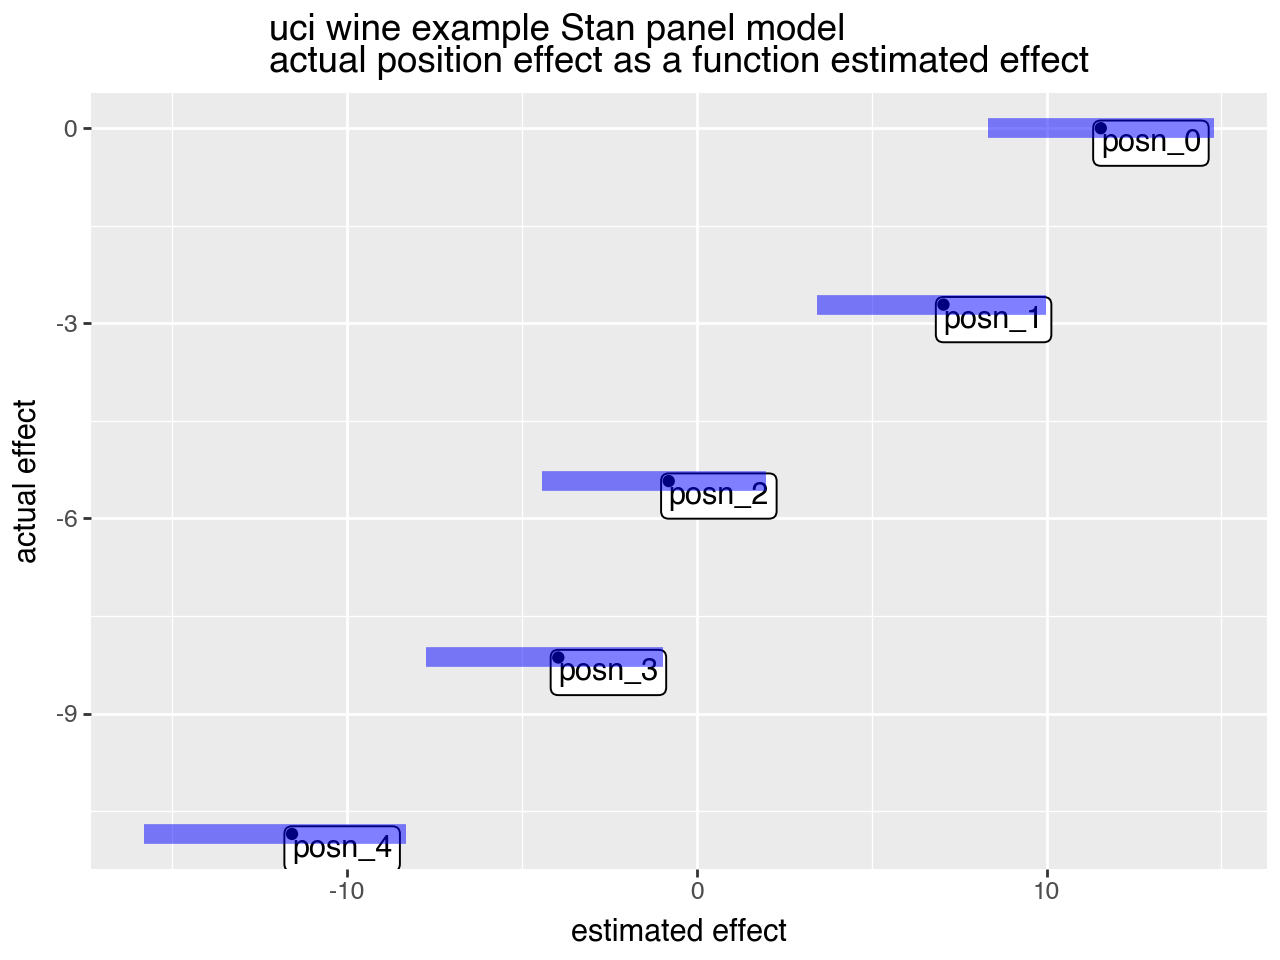

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6488,False
1,0,1,0.1778,False
2,0,2,0.1284,True
3,0,3,0.0392,False
4,0,4,0.0058,False
5,1,0,0.4379,True
6,1,1,0.3031,False
7,1,2,0.1148,False
8,1,3,0.1282,False
9,1,4,0.0160,False


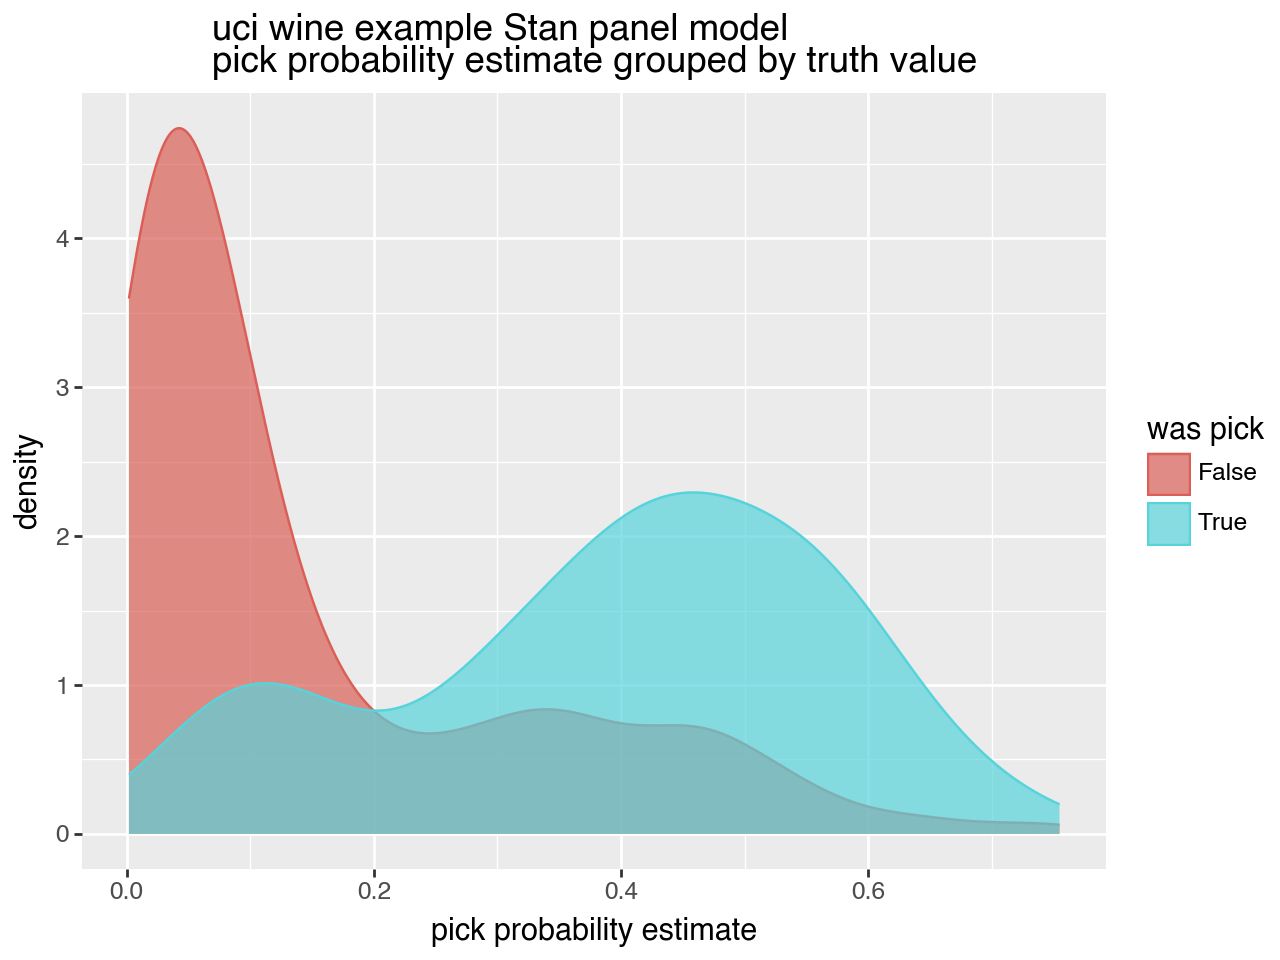

<Figure size 640x480 with 0 Axes>

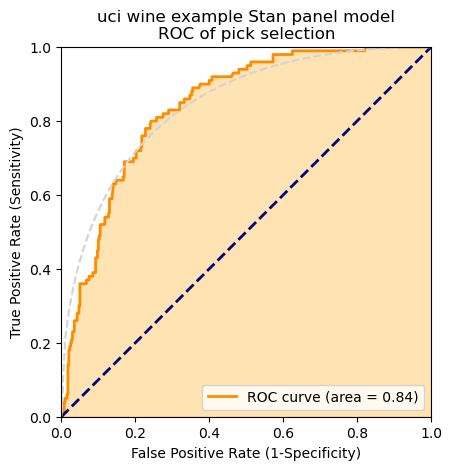

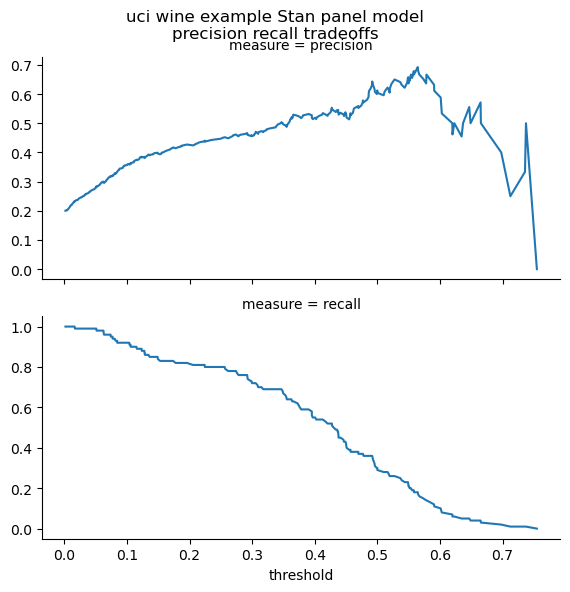

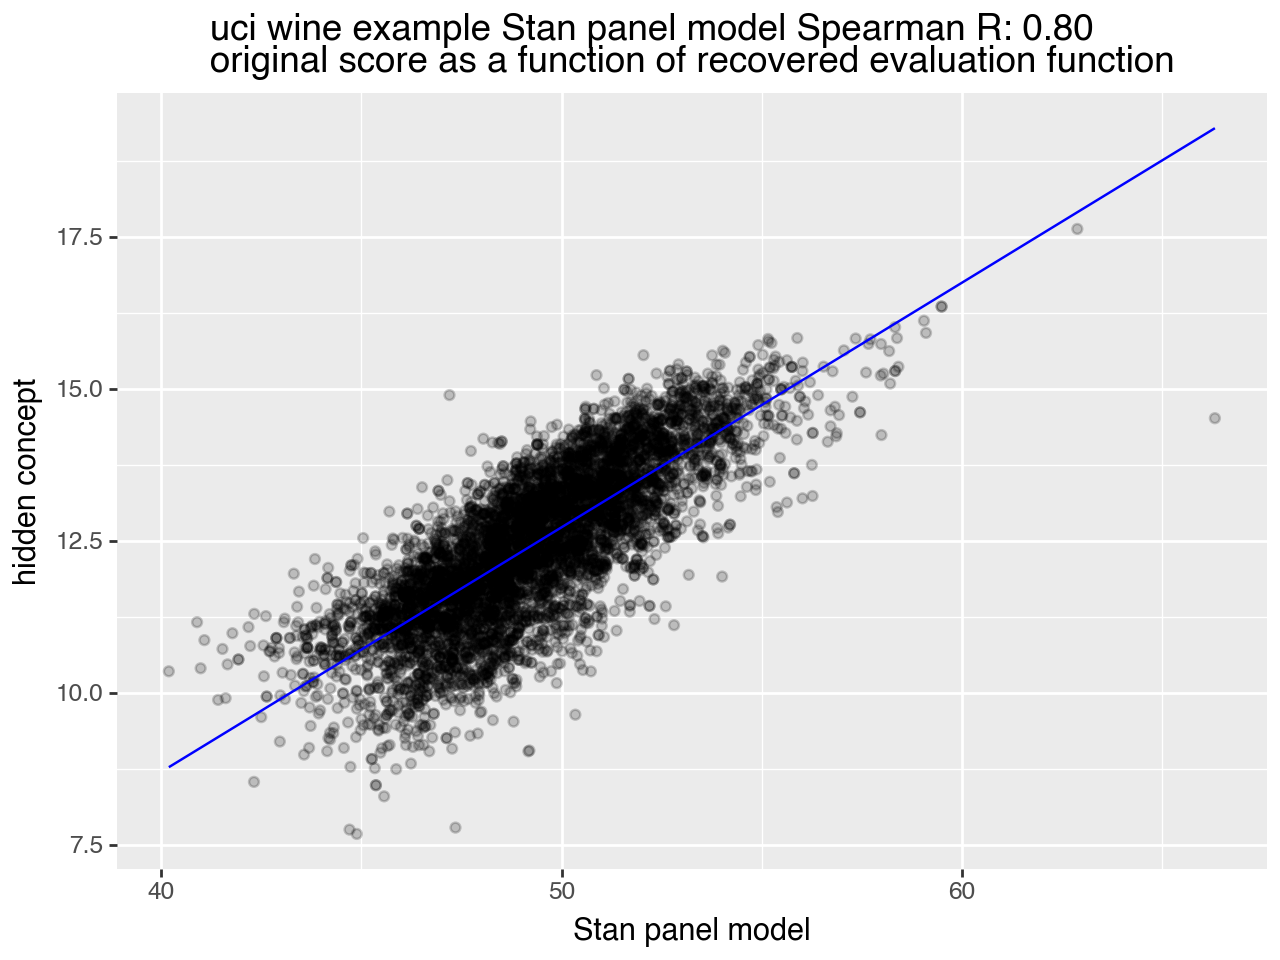

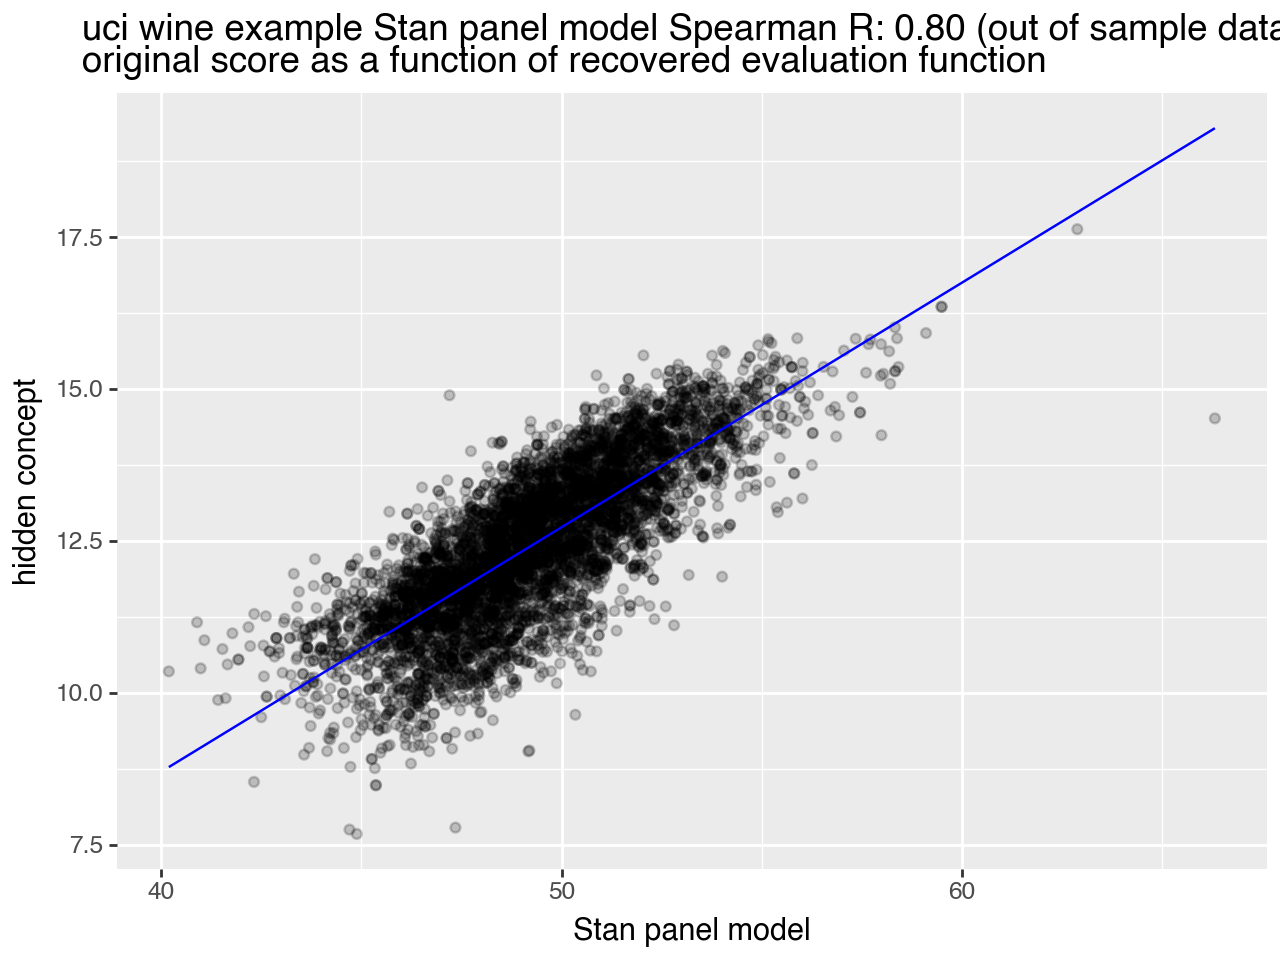

In [31]:
stat_pull = plot_rank_performance(
    estimated_beta=estimated_beta_Stan,               # estimated coefficients
    example_name=example_name,                        # name of data set
    n_vars=n_vars,                                    # number of variables (including position variables)
    n_alternatives=n_alternatives,                    # size of panels
    features_frame=features_frame,                    # features by row id
    observations=observations,                        # observation layout frame
    estimate_name="Stan panel model",                       # display name of estimate
    position_quantiles=position_quantiles,            # quantiles of estimated positions
    position_penalties=position_penalties,            # ideal position penalties
    score_compare_frame=score_compare_frame,          # score comparison frame (altered by call)
    rng=rng,                                          # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

Try to approximate the Stan model with a logistic model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [32]:
feature_names = list(features_frame.columns) + [f'position_{sel_i}' for sel_i in range(n_alternatives)]
enc_frame = []
for row_i in range(observations.shape[0]):
     feature_row = observations.loc[row_i, :]
     sel_pick = np.argmax(
     feature_row[[f'pick_value_{sel_i}' for sel_i in range(n_alternatives)]])
     for sel_i in range(n_alternatives):
          if sel_i != sel_pick:
               posn_vec = [0] * n_alternatives
               posn_vec[sel_pick] = 1.0
               posn_vec[sel_i] = -1.0
               encoded_row = list(features_frame.loc[feature_row[f'item_id_{sel_pick}'], :] 
                    - features_frame.loc[feature_row[f'item_id_{sel_i}'], :]) + posn_vec
               di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
               enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)


In [33]:
enc_frame.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,position_0,position_1,position_2,position_3,position_4
0,-0.2,-0.170,0.15,4.2,-0.010,14.0,100.0,0.00066,0.00,0.00,-0.8,-1.0,0.0,1.0,0.0,0.0
1,-1.4,0.100,-0.13,-7.9,-0.020,-19.0,-64.0,-0.00328,0.59,0.15,1.8,0.0,-1.0,1.0,0.0,0.0
2,-1.5,-0.080,-0.16,-3.0,0.017,9.0,9.0,-0.00138,0.36,0.21,0.6,0.0,0.0,1.0,-1.0,0.0
3,-1.0,0.030,-0.23,4.4,0.017,24.0,73.0,0.00282,0.41,0.14,0.3,0.0,0.0,1.0,0.0,-1.0
4,-0.8,0.095,0.17,5.7,0.002,-12.5,-25.0,0.00264,0.04,-0.12,-0.7,1.0,-1.0,0.0,0.0,0.0


In [34]:
logistic_model = LogisticRegression(max_iter=10000, solver='newton-cholesky')
logistic_model.fit(
    pd.concat([enc_frame, -enc_frame], ignore_index=True),
    [True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)


LogisticRegression(max_iter=10000, solver='newton-cholesky')

estimated position influences


,position,estimated effect,actual effect
0,posn_0,1.700493,-0.0000
1,posn_1,1.039723,-2.7123
2,posn_2,-0.100792,-5.4246
3,posn_3,-0.581897,-8.1369
4,posn_4,-2.057526,-10.8492


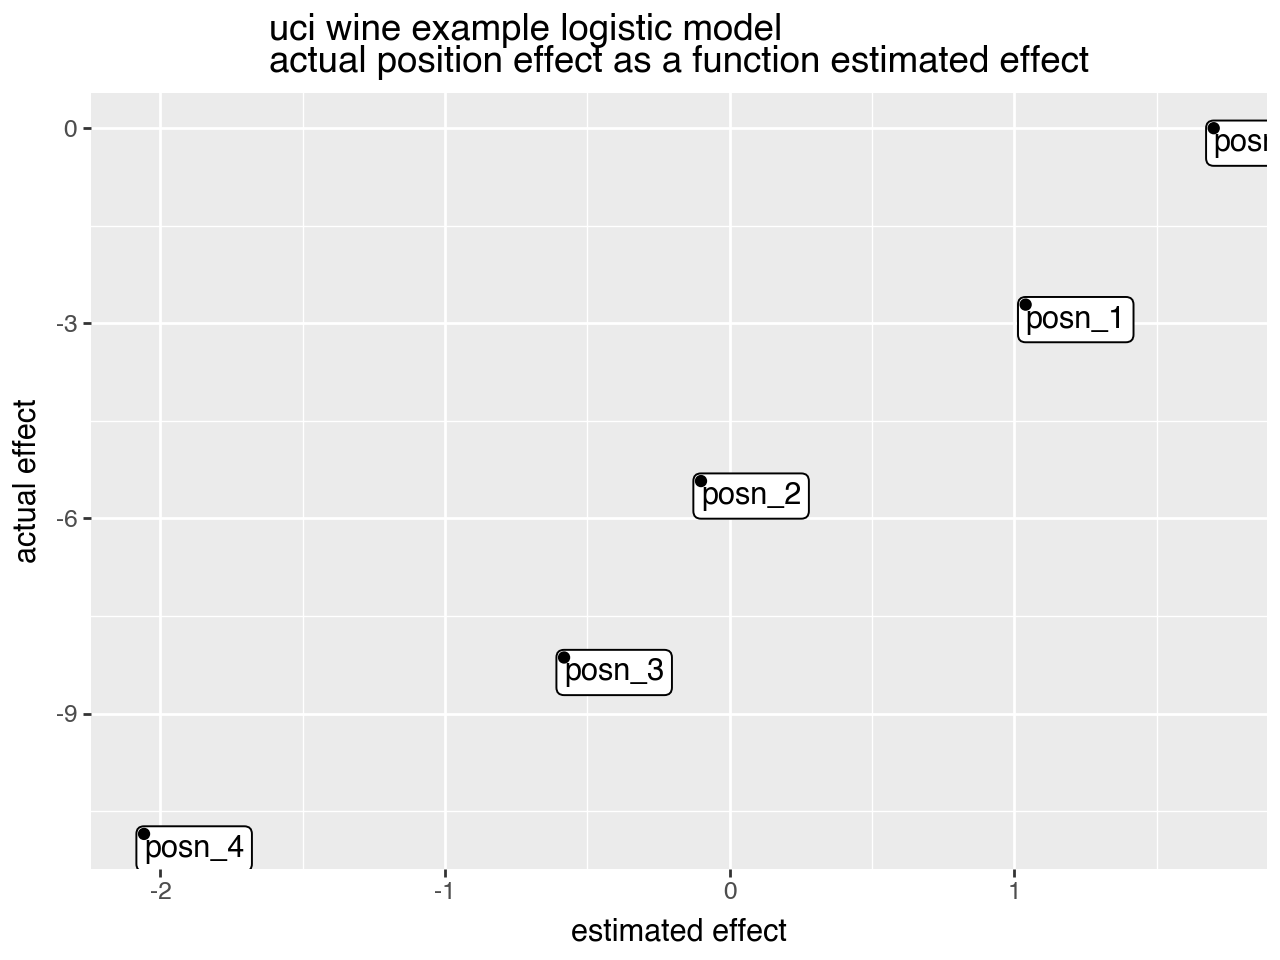

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2618,False
1,0,1,0.2205,False
2,0,2,0.2082,True
3,0,3,0.1775,False
4,0,4,0.1320,False
5,1,0,0.2349,True
6,1,1,0.2231,False
7,1,2,0.1996,False
8,1,3,0.1982,False
9,1,4,0.1442,False


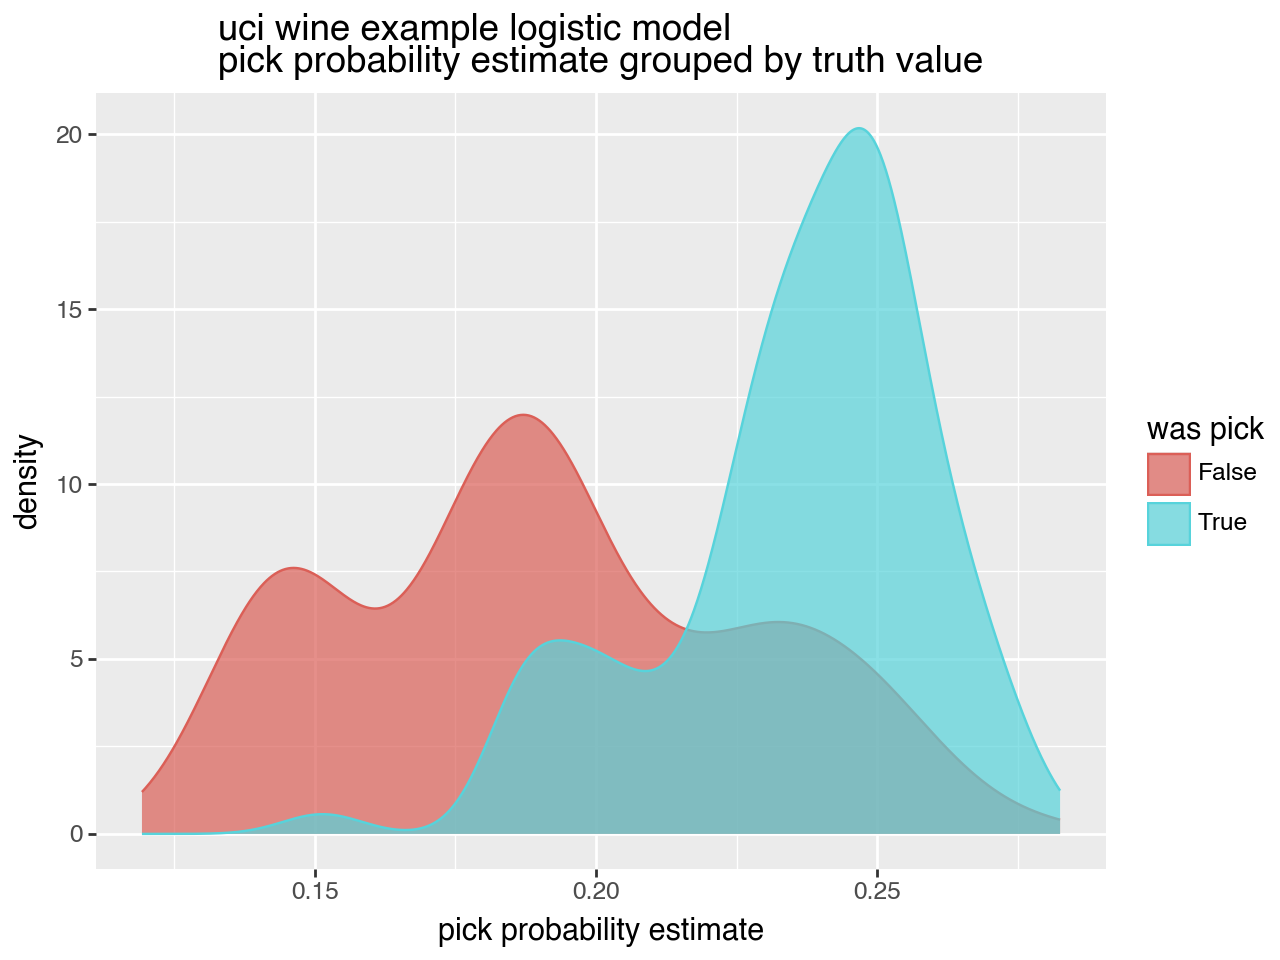

<Figure size 640x480 with 0 Axes>

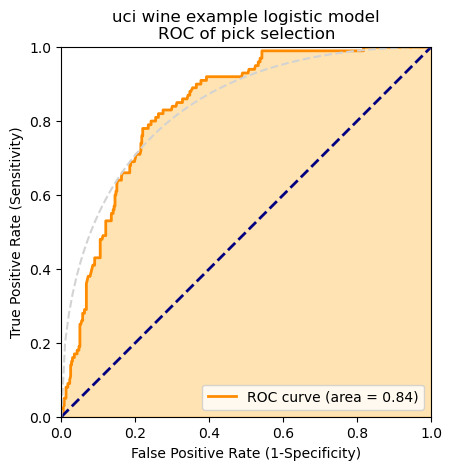

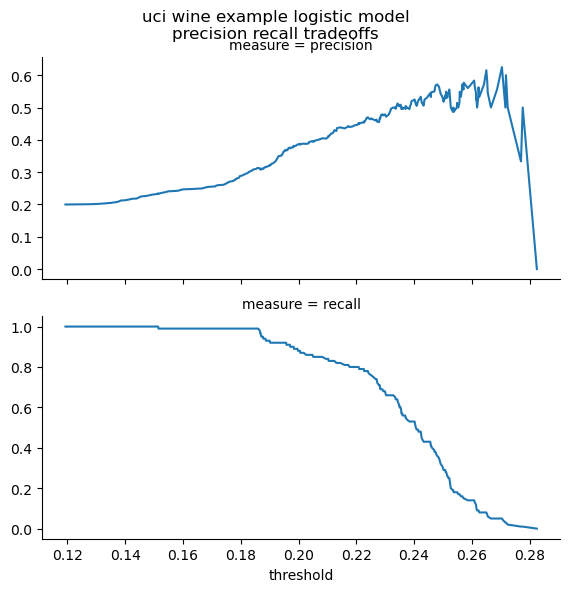

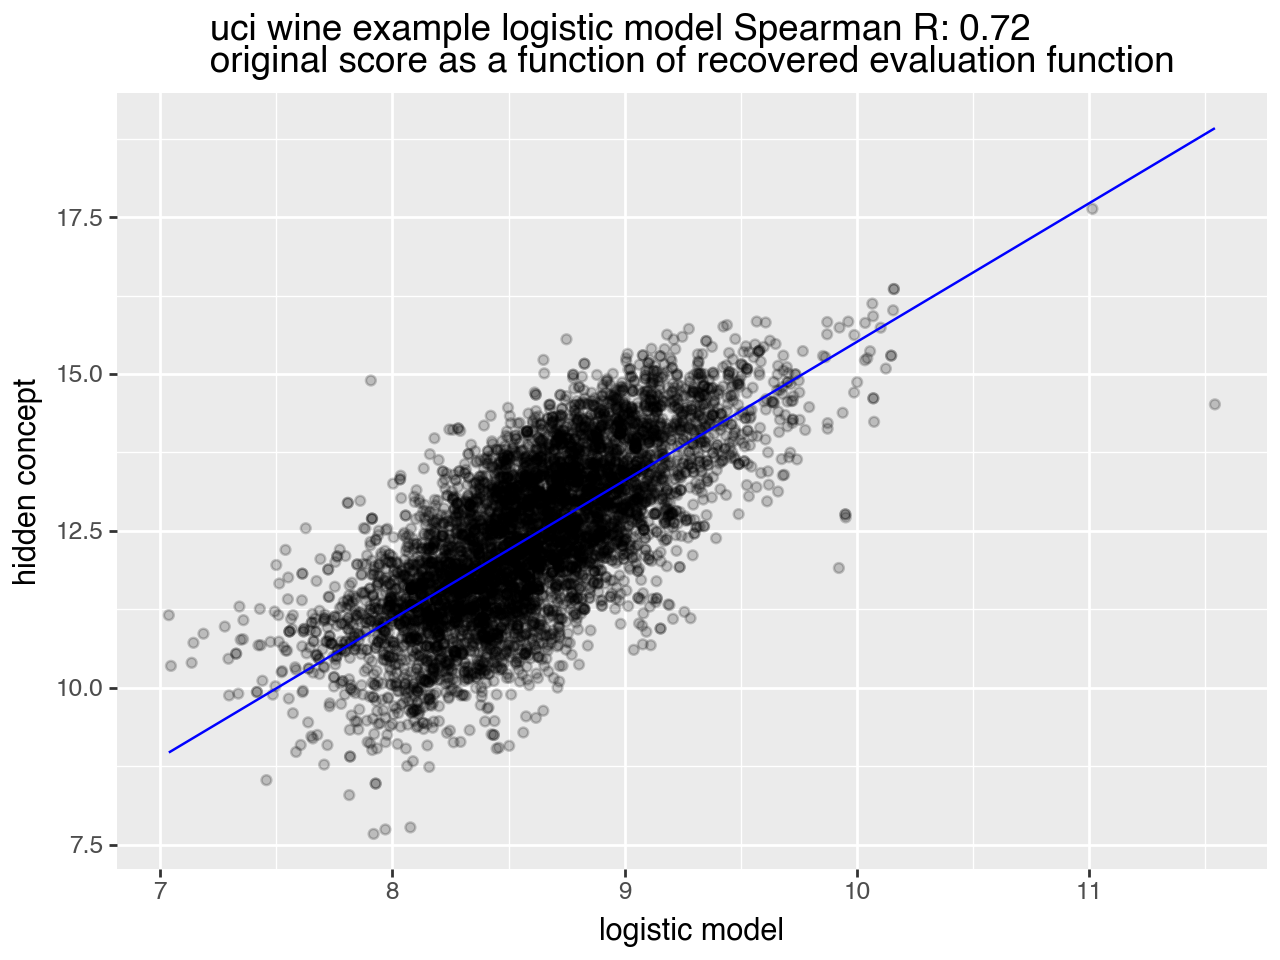

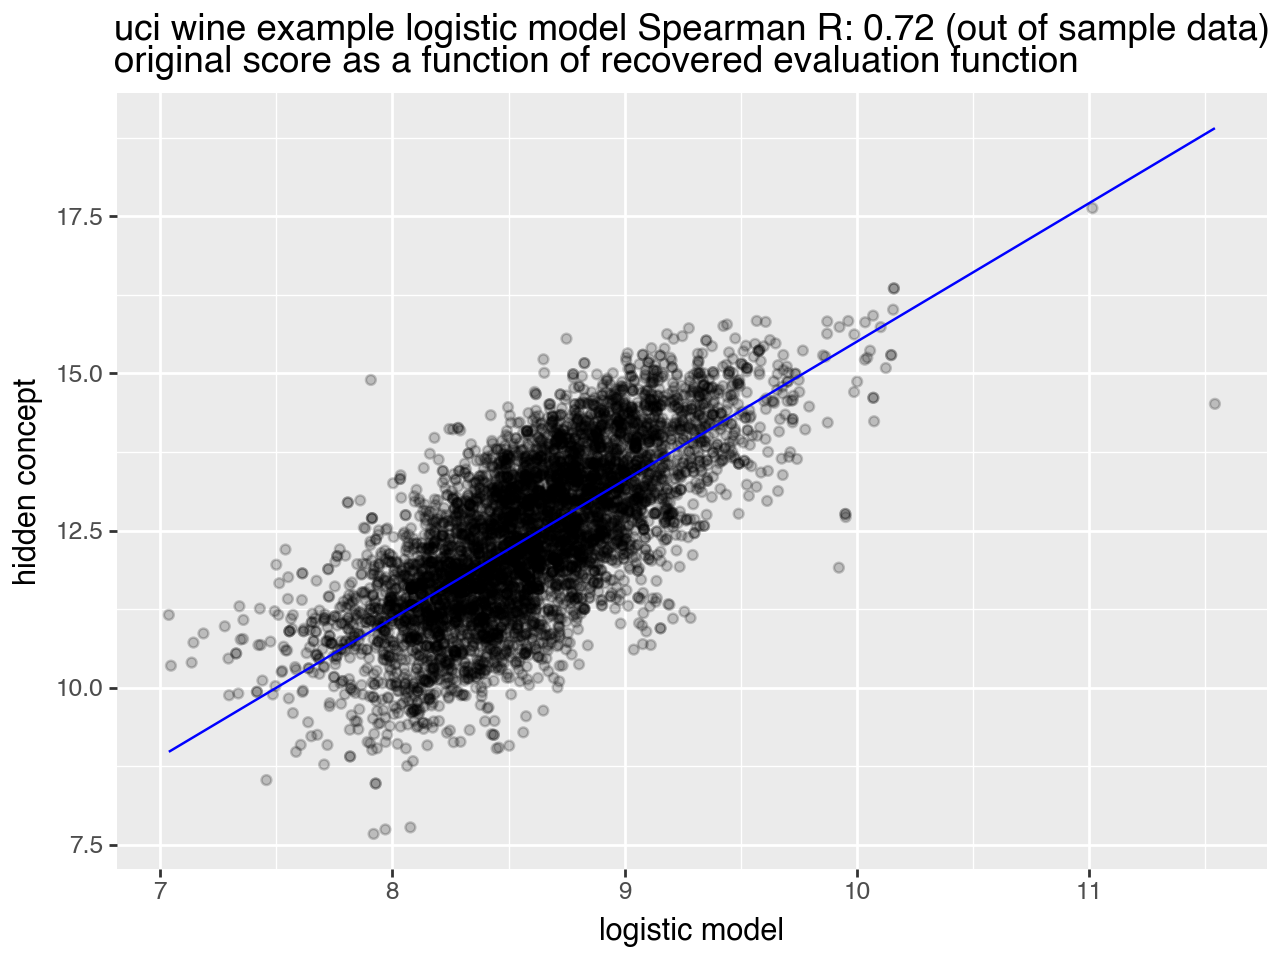

In [35]:
stat_pull = plot_rank_performance(
    estimated_beta=logistic_model.coef_[0],           # estimated coefficients
    example_name=example_name,                        # name of data set
    n_vars=n_vars,                                    # number of variables (including position variables)
    n_alternatives=n_alternatives,                    # size of panels
    features_frame=features_frame,                    # features by row id
    observations=observations,                        # observation layout frame
    estimate_name="logistic model",                   # display name of estimate
    position_quantiles=None,                          # quantiles of estimated positions
    position_penalties=position_penalties,            # ideal position penalties
    score_compare_frame=score_compare_frame,          # score comparison frame (altered by call)
    rng=rng,                                          # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

We can also try a related Stan model per-comparison, instead of per-panel.

In [36]:
stan_model_comparison_src = (
"""
data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
"""
  + ''.join([f"""  matrix[m_examples, n_vars] x_passed_{i};   // character of passed examples
""" for i in range(1, n_alternatives)])
  + """}
parameters {
  vector[n_vars] beta;                      // model parameters
}
transformed parameters {
  vector[m_examples] expect_picked;
"""
  + ''.join([f"""  vector[m_examples] expect_passed_{i};
""" for i in range(1, n_alternatives)])
  + """  expect_picked = x_picked * beta;          // modeled expected score of picked item
"""
  + ''.join([f"""  expect_passed_{i} = x_passed_{i} * beta;      // modeled expected score of passed item
""" for i in range(1, n_alternatives)])
  +"""}
model {
    // basic priors
  beta ~ normal(0, 10);
    // log probability of observed ordering as a function of parameters
"""
  + ''.join([f"""  target += normal_lcdf( 0 | expect_passed_{i} - expect_picked, sqrt(2) * 10);
""" for i in range(1, n_alternatives)])
  + """}
"""
)

if do_display:
  print(stan_model_comparison_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // modeled expected score of picked item
  expect_passed_1 = x_passed_1 * beta;      // modeled expected score of passed item
  expe

In [37]:
fit_comp = run_stan_model(
        stan_model_src=stan_model_comparison_src,
        data_str=data_str,
)

In [38]:
# get implied sample weights from chain
wt_frame_c = fit_comp.draws_pd(vars=['lp__'])
if do_display:
    (
        ggplot(
            data=wt_frame_c,
            mapping=aes(x='lp__'),
        )
        + geom_density(fill='gray', alpha=0.7)
        + ggtitle(f'{example_name} Stan lp__ value on comparison draws')
    )

In [39]:
beta_draws_c = fit_comp.draws_pd(vars=['beta'])
estimated_beta_Stan_c = beta_draws_c.loc[wt_frame_c['lp__'] >= np.quantile(wt_frame_c['lp__'], 0.9), :].mean()
#estimated_beta_Stan_c = beta_draws_c.mean()

In [40]:

position_quantiles_c = (
    beta_draws_c
        .iloc[:, features_frame.shape[1]:n_vars]
        .quantile((0.25, 0.5, 0.75))
        .transpose()
        .reset_index(drop=True, inplace=False)
)
position_quantiles_c.columns = [str(c) for c in position_quantiles_c.columns]


estimated position influences


,position,estimated effect,actual effect,0.25,0.5,0.75
0,posn_0,13.966159,-0.0000,11.155000,14.250350,17.371125
1,posn_1,8.617145,-2.7123,5.633633,8.876755,11.992300
2,posn_2,-0.971698,-5.4246,-4.069715,-0.846183,2.341285
3,posn_3,-5.358960,-8.1369,-8.479588,-5.236645,-1.920758
4,posn_4,-16.487410,-10.8492,-20.077175,-16.746300,-13.389600


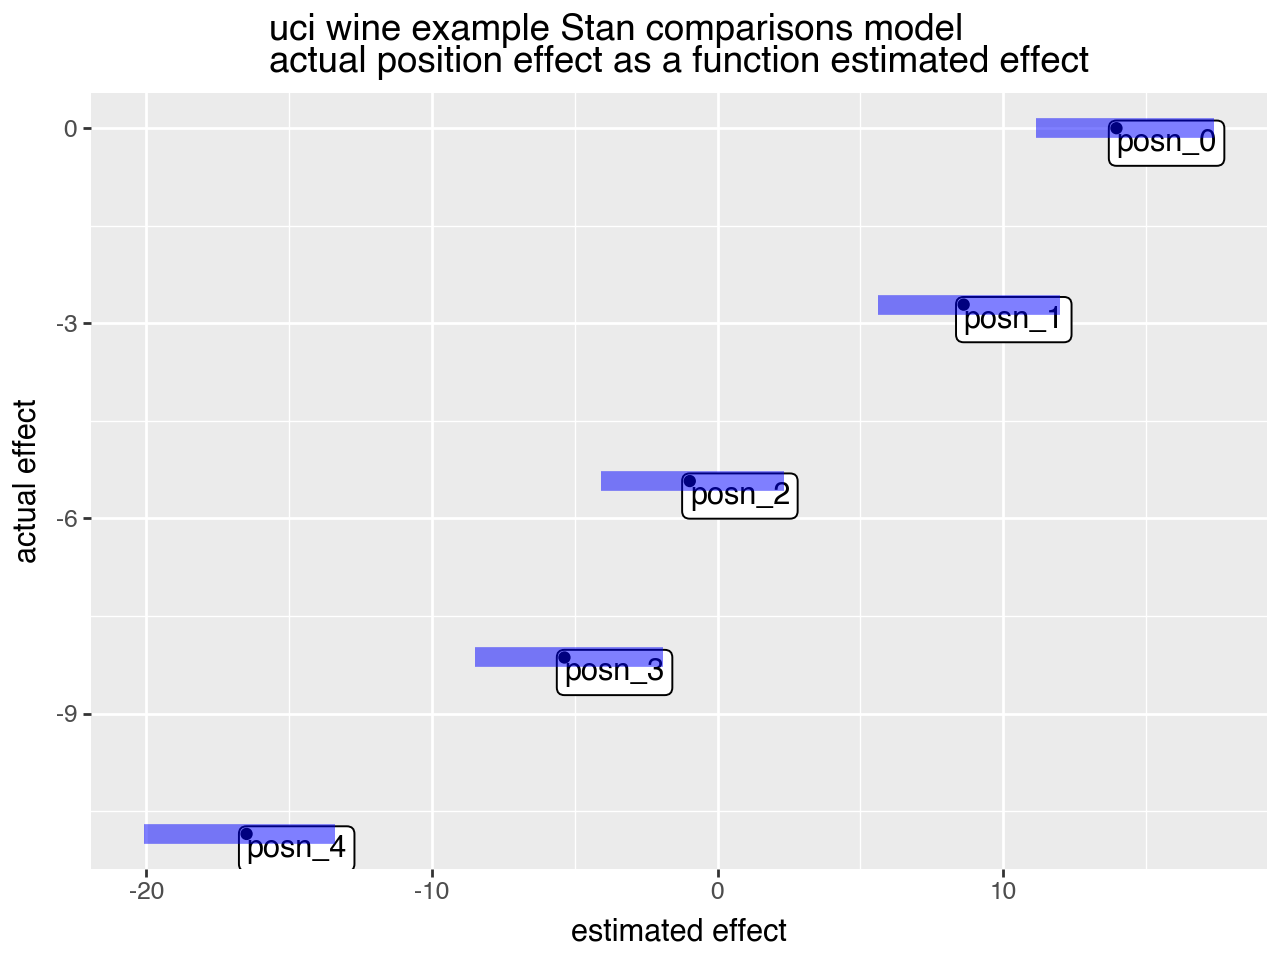

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6765,False
1,0,1,0.1834,False
2,0,2,0.1187,True
3,0,3,0.0207,False
4,0,4,0.0007,False
5,1,0,0.4603,True
6,1,1,0.3443,False
7,1,2,0.1062,False
8,1,3,0.0854,False
9,1,4,0.0038,False


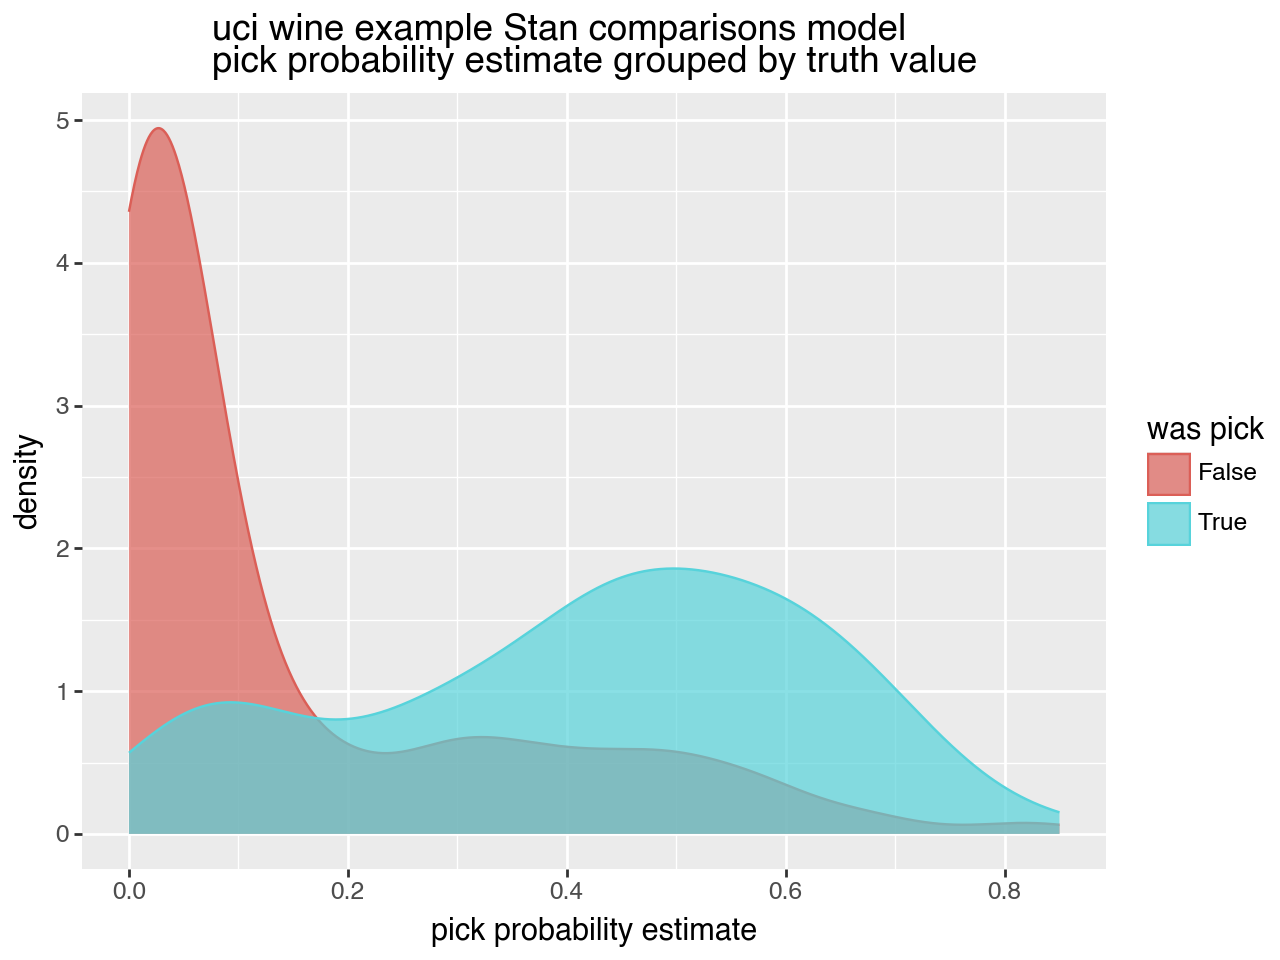

<Figure size 640x480 with 0 Axes>

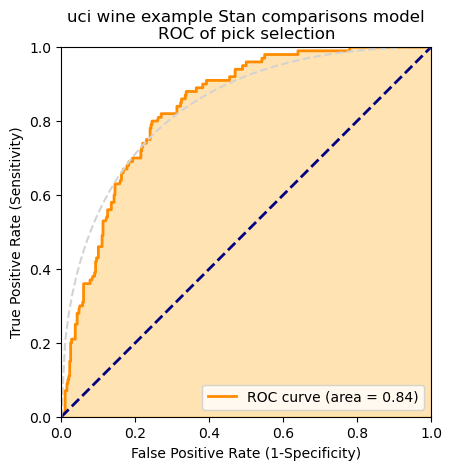

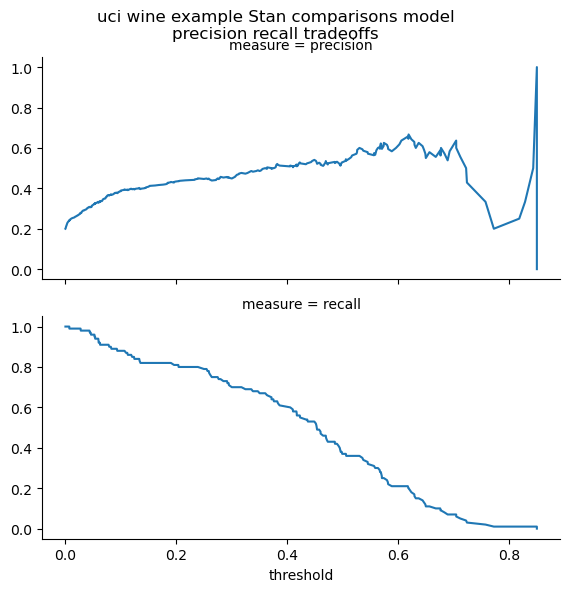

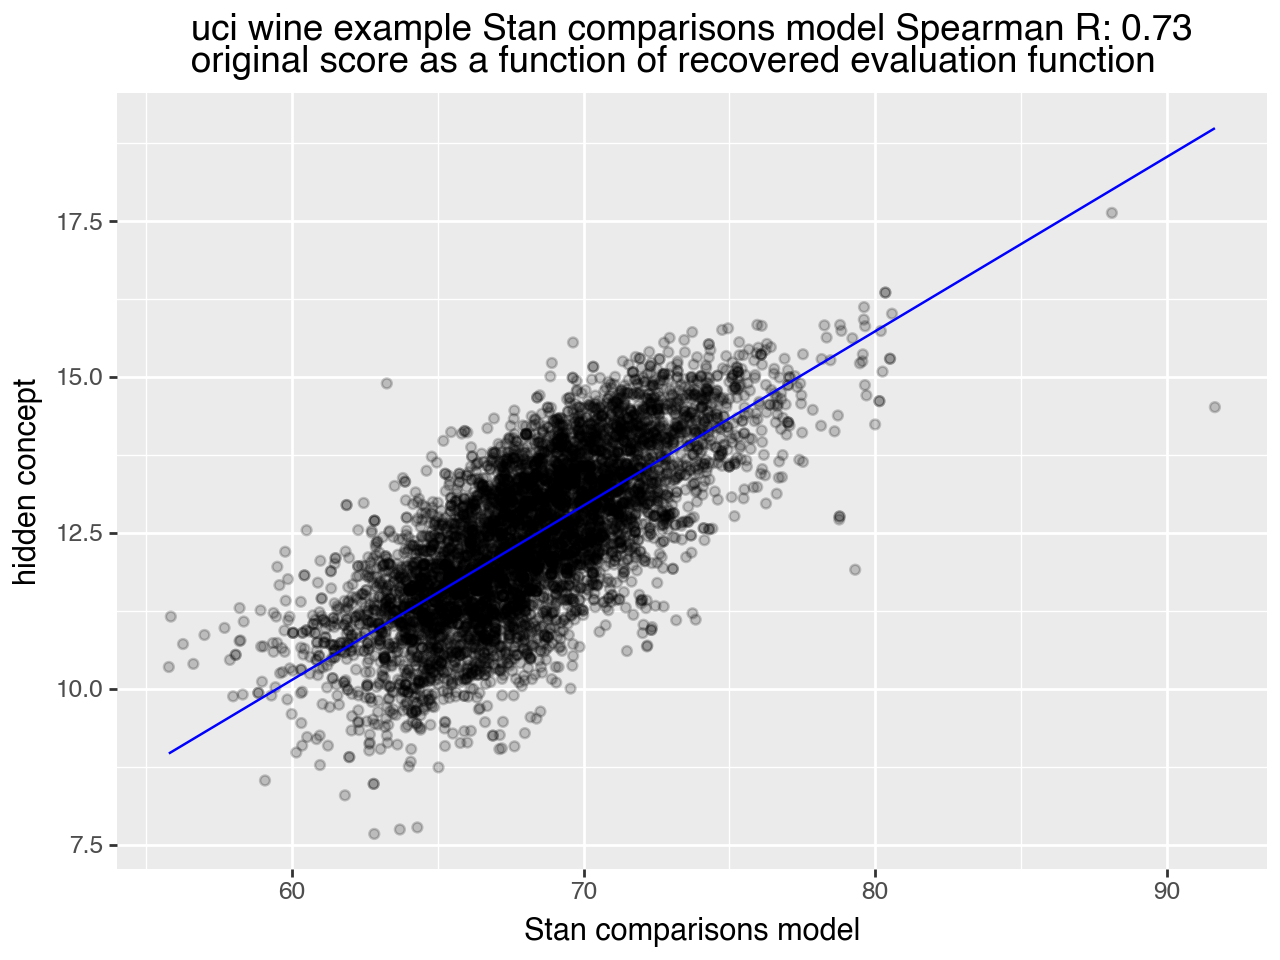

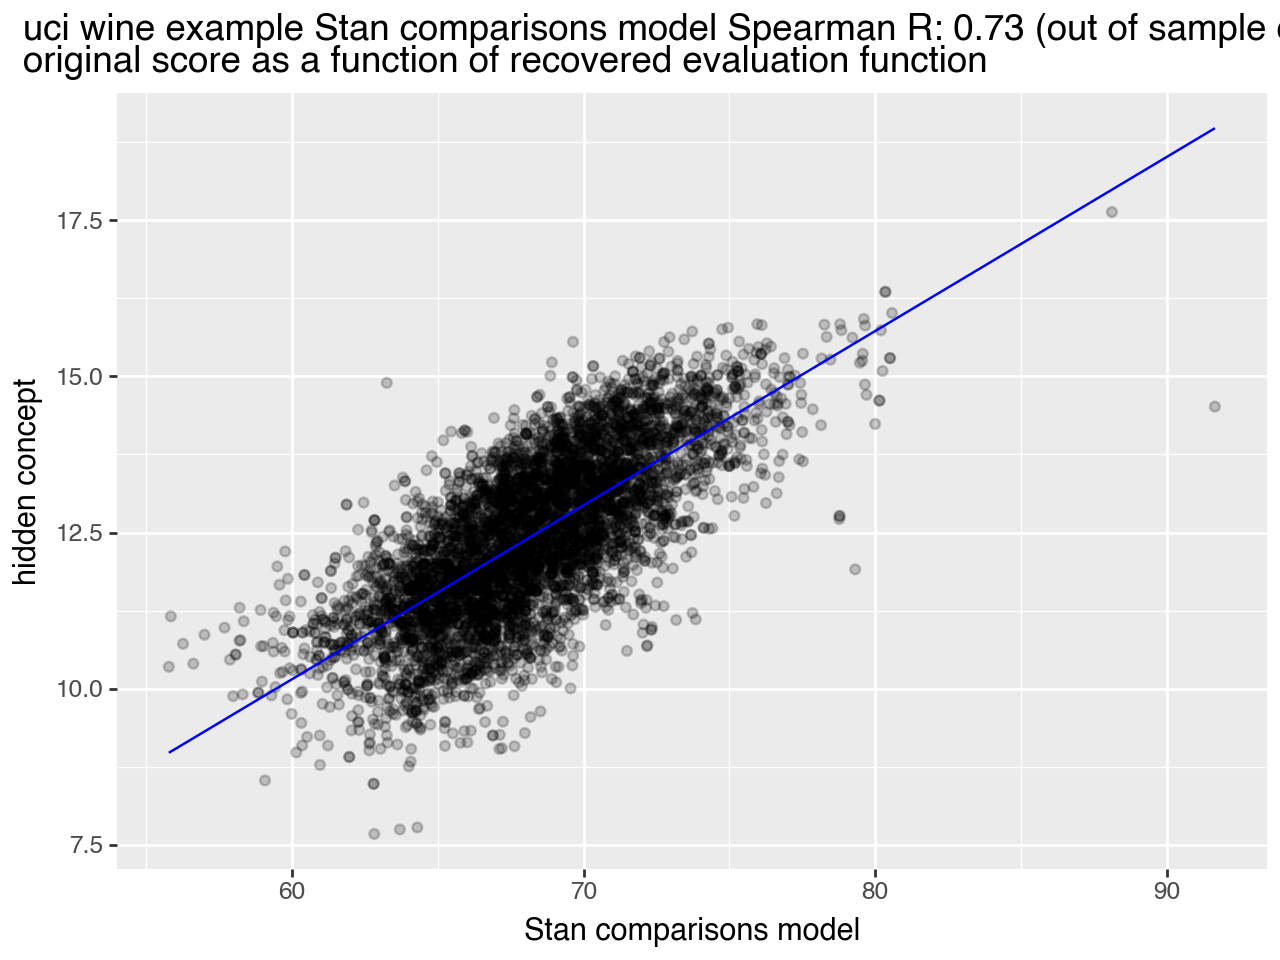

In [41]:
stat_pull = plot_rank_performance(
    estimated_beta=estimated_beta_Stan_c,             # estimated coefficients
    example_name=example_name,                        # name of data set
    n_vars=n_vars,                                    # number of variables (including position variables)
    n_alternatives=n_alternatives,                    # size of panels
    features_frame=features_frame,                    # features by row id
    observations=observations,                        # observation layout frame
    estimate_name="Stan comparisons model",           # display name of estimate
    position_quantiles=position_quantiles_c,          # quantiles of estimated positions
    position_penalties=position_penalties,            # ideal position penalties
    score_compare_frame=score_compare_frame,          # score comparison frame (altered by call)
    rng=rng,                                          # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

In [42]:
collected_stats = pd.concat(collected_stats, ignore_index=True)

In [43]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [44]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_SpearmanR,pick_auc,data_size,test_size
0,uci wine example,Stan panel model,0.800962,0.801398,0.472280,0.840838,6497,6013
1,uci wine example,logistic model,0.720157,0.719287,0.466495,0.836662,6497,6013
2,uci wine example,Stan comparisons model,0.729958,0.729175,0.468504,0.838113,6497,6013
